In [17]:
import pandas as pd

In [19]:
train = pd.read_csv("C:/Users/kprab/Downloads/archive (3)/train.csv", parse_dates=["Date"])
stores = pd.read_csv("C:/Users/kprab/Downloads/archive (3)/stores.csv")
test  = pd.read_csv("C:/Users/kprab/Downloads/archive (3)/test.csv",parse_dates=["Date"])
features = pd.read_csv("C:/Users/kprab/Downloads/archive (3)/features.csv",parse_dates=["Date"])

In [21]:
# Merge store info
train = train.merge(stores, on="Store", how="left")
test  = test.merge(stores, on="Store", how="left")

In [23]:
train = train.merge(features, on=["Store","Date"], how="left")
test  = test.merge(features, on=["Store","Date"], how="left")

In [25]:
# Add time features
def add_time_features(df):
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    df["IsWeekend"] = df["DayOfWeek"].isin([5,6]).astype(int)
    return df

In [27]:
train = add_time_features(train)
test  = add_time_features(test)

print(train.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday_x Type    Size  \
0      1     1 2010-02-05      24924.50        False    A  151315   
1      1     1 2010-02-12      46039.49         True    A  151315   
2      1     1 2010-02-19      41595.55        False    A  151315   
3      1     1 2010-02-26      19403.54        False    A  151315   
4      1     1 2010-03-05      21827.90        False    A  151315   

   Temperature  Fuel_Price  MarkDown1  ...  MarkDown4  MarkDown5         CPI  \
0        42.31       2.572        NaN  ...        NaN        NaN  211.096358   
1        38.51       2.548        NaN  ...        NaN        NaN  211.242170   
2        39.93       2.514        NaN  ...        NaN        NaN  211.289143   
3        46.63       2.561        NaN  ...        NaN        NaN  211.319643   
4        46.50       2.625        NaN  ...        NaN        NaN  211.350143   

   Unemployment  IsHoliday_y  Year  Month  Week  DayOfWeek  IsWeekend  
0         8.106        False  20

In [29]:
# Encode 'Type' as numeric
if "Type" in train.columns:
    mapper = {"A": 0, "B": 1, "C": 2}
    train["Type"] = train["Type"].map(mapper).astype("float32")
    test["Type"]  = test["Type"].map(mapper).astype("float32")

In [31]:
common = list(set(train.columns) & set(test.columns))
drop_cols = ["Weekly_Sales","Date"]  # target + date
feat_cols = [c for c in common if c not in drop_cols]


In [33]:
X = train[feat_cols]
y = train["Weekly_Sales"]

# Sort by date for proper time split
train_sorted = train.sort_values("Date")
split_idx = int(len(train_sorted)*0.8)

X_train, y_train = train_sorted[feat_cols].iloc[:split_idx], train_sorted["Weekly_Sales"].iloc[:split_idx]
X_valid, y_valid = train_sorted[feat_cols].iloc[split_idx:], train_sorted["Weekly_Sales"].iloc[split_idx:]


In [35]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

model = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("hgb", HistGradientBoostingRegressor(
        max_depth=8,
        learning_rate=0.05,
        max_bins=255,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    ))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("Validation RMSE:", rmse)


Validation RMSE: 7804.617328496716


In [36]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [37]:
# 0) Load & basic merges
# -----------------------------
train = pd.read_csv("C:/Users/kprab/Downloads/archive (3)/train.csv", parse_dates=["Date"])
stores = pd.read_csv("C:/Users/kprab/Downloads/archive (3)/stores.csv")
features = pd.read_csv("C:/Users/kprab/Downloads/archive (3)/features.csv", parse_dates=["Date"])

In [41]:
# --- Safety checks on target before transform ---
def summarize_target(name, y):
    y = pd.Series(y)
    print(f"{name}: n={y.size}, NaNs={y.isna().sum()}, "
          f"negatives={(y<0).sum()}, min={y.min():.2f}, max={y.max():.2f}")

In [43]:
summarize_target("y_train(raw)", y_train)
summarize_target("y_valid(raw)", y_valid)

y_train(raw): n=337256, NaNs=0, negatives=990, min=-4988.94, max=693099.36
y_valid(raw): n=84314, NaNs=0, negatives=295, min=-771.90, max=206575.90


In [45]:
# Drop rows with missing target if any (rare, but safe)
mask_train = ~pd.Series(y_train).isna().values
mask_valid = ~pd.Series(y_valid).isna().values
X_train, y_train = X_train.iloc[mask_train], y_train[mask_train]
X_valid, y_valid = X_valid.iloc[mask_valid], y_valid[mask_valid]

In [47]:
# --- Use asinh transform (handles negatives) ---
def y_forward(y):   # R -> R
    return np.arcsinh(y)

In [49]:
def y_inverse(z):  # R -> R
    return np.sinh(z)

In [51]:
y_train_t = y_forward(y_train)
y_valid_t = y_forward(y_valid)

In [53]:
# --- Model pipeline ---
model = Pipeline([
    ("imp", SimpleImputer(strategy="median")),  # imputes sparse MarkDowns, CPI, etc.
    ("hgb", HistGradientBoostingRegressor(
        max_depth=8,
        learning_rate=0.05,
        max_bins=255,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    ))
])


In [55]:
print("Training...")
model.fit(X_train, y_train_t)

Training...


Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('hgb',
                 HistGradientBoostingRegressor(early_stopping=True,
                                               learning_rate=0.05, max_depth=8,
                                               random_state=42))])

In [57]:
print("Validating...")
valid_pred_t = model.predict(X_valid)
valid_pred = y_inverse(valid_pred_t)

Validating...


In [59]:
# Optional clamp: sales shouldn't be < 0; clamp tiny negatives from numerical noise
valid_pred = np.maximum(valid_pred, 0)

In [61]:
rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
print(f"Validation RMSE (lags+rolling + asinh target): {rmse:,.2f}")

Validation RMSE (lags+rolling + asinh target): 11,879.28


In [63]:
def add_holiday_flags(df):
    df = df.copy()
    df["SuperBowl"] = df["Date"].between("2010-02-05","2010-02-11") | \
                      df["Date"].between("2011-02-04","2011-02-10") | \
                      df["Date"].between("2012-02-03","2012-02-09")
    df["LaborDay"] = df["Date"].between("2010-09-03","2010-09-09") | \
                     df["Date"].between("2011-09-02","2011-09-08") | \
                     df["Date"].between("2012-08-31","2012-09-06")
    df["Thanksgiving"] = df["Date"].between("2010-11-26","2010-12-02") | \
                         df["Date"].between("2011-11-25","2011-12-01") | \
                         df["Date"].between("2012-11-23","2012-11-29")
    df["Christmas"] = df["Date"].between("2010-12-24","2010-12-30") | \
                      df["Date"].between("2011-12-23","2011-12-29") | \
                      df["Date"].between("2012-12-21","2012-12-27")
    # convert bool to int
    for col in ["SuperBowl","LaborDay","Thanksgiving","Christmas"]:
        df[col] = df[col].astype(int)
    return df

train = add_holiday_flags(train)


In [65]:
params_grid = [
    {"max_depth":6, "learning_rate":0.03},
    {"max_depth":8, "learning_rate":0.03},
    {"max_depth":10,"learning_rate":0.05},
]

best_rmse = 1e9
best_params = None

for p in params_grid:
    model = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("hgb", HistGradientBoostingRegressor(
            max_depth=p["max_depth"],
            learning_rate=p["learning_rate"],
            max_bins=255,
            l2_regularization=1.0,  # helps generalization
            early_stopping=True,
            validation_fraction=0.1,
            random_state=42
        ))
    ])
    model.fit(X_train, np.arcsinh(y_train))
    pred = np.sinh(model.predict(X_valid))
    pred = np.maximum(pred,0)  # clamp small negatives
    rmse = np.sqrt(mean_squared_error(y_valid, pred))
    print(f"Params {p} -> RMSE {rmse:,.2f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = p

print("\nBest Params:", best_params, "with RMSE:", best_rmse)


Params {'max_depth': 6, 'learning_rate': 0.03} -> RMSE 15,528.31
Params {'max_depth': 8, 'learning_rate': 0.03} -> RMSE 14,870.05
Params {'max_depth': 10, 'learning_rate': 0.05} -> RMSE 12,036.44

Best Params: {'max_depth': 10, 'learning_rate': 0.05} with RMSE: 12036.444659807847


In [66]:
# Drop target + Date, keep common cols
common = list(set(train.columns) & set(test.columns))
drop_cols = ["Weekly_Sales", "Date"]
feat_cols = [c for c in common if c not in drop_cols]


In [67]:
X_full = train[feat_cols]
y_full = train["Weekly_Sales"]

best_model = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("hgb", HistGradientBoostingRegressor(
        max_depth=10,
        learning_rate=0.05,
        max_bins=255,
        l2_regularization=1.0,
        random_state=42
    ))
])

best_model.fit(X_full, np.arcsinh(y_full))   # train on all


Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('hgb',
                 HistGradientBoostingRegressor(l2_regularization=1.0,
                                               learning_rate=0.05, max_depth=10,
                                               random_state=42))])

In [68]:
X_test = test[feat_cols]
test_preds = np.sinh(best_model.predict(X_test))   # invert transform
test_preds = np.maximum(test_preds, 0)             # clamp negatives


In [73]:
submission = test[["Store","Dept","Date"]].copy()
submission["Weekly_Sales"] = test_preds
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved")


✅ submission.csv saved


In [75]:
print(submission.head(10))

   Store  Dept       Date  Weekly_Sales
0      1     1 2012-11-02  21412.135779
1      1     1 2012-11-09  21412.135779
2      1     1 2012-11-16  21412.135779
3      1     1 2012-11-23  21412.135779
4      1     1 2012-11-30  21412.135779
5      1     1 2012-12-07  21412.135779
6      1     1 2012-12-14  21412.135779
7      1     1 2012-12-21  21412.135779
8      1     1 2012-12-28  21412.135779
9      1     1 2013-01-04  21412.135779


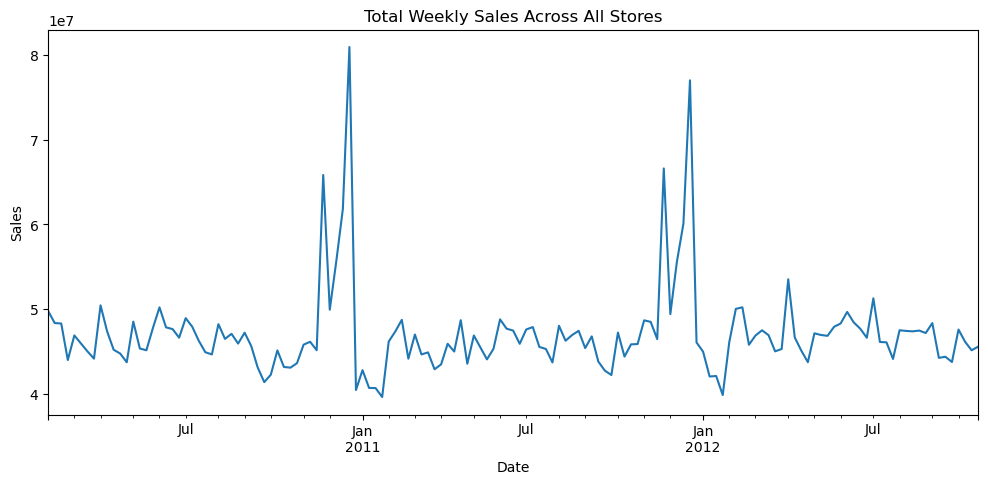

In [77]:
import matplotlib.pyplot as plt

train.groupby("Date")["Weekly_Sales"].sum().plot(figsize=(12,5))
plt.title("Total Weekly Sales Across All Stores")
plt.ylabel("Sales")
plt.show()


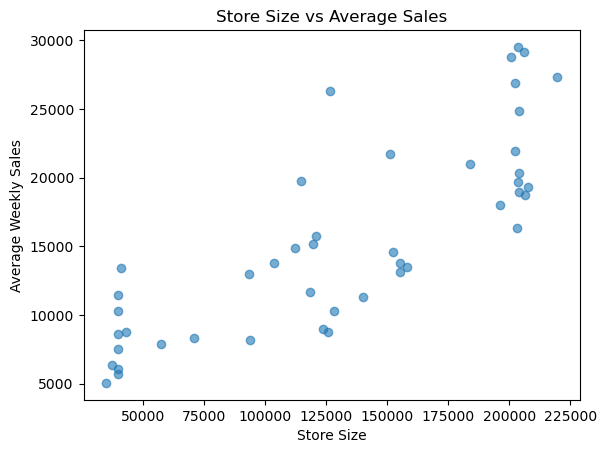

In [79]:
store_sales = train.groupby("Store")["Weekly_Sales"].mean().reset_index()
store_info = stores.merge(store_sales, on="Store")
plt.scatter(store_info["Size"], store_info["Weekly_Sales"], alpha=0.6)
plt.xlabel("Store Size")
plt.ylabel("Average Weekly Sales")
plt.title("Store Size vs Average Sales")
plt.show()


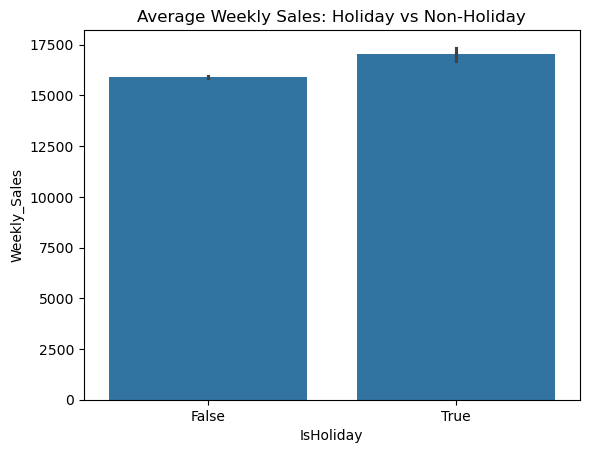

In [81]:
import seaborn as sns
sns.barplot(data=train, x="IsHoliday", y="Weekly_Sales")
plt.title("Average Weekly Sales: Holiday vs Non-Holiday")
plt.show()
